In [1]:
# Kaggle project for NLP (02-20-2019)

# This is the first project in NLP.

# We are a two-member group:
# Ramesh Subedi
# Ravi Dawar

# It takes more than 12 hours to run this whole code.

import numpy as np
import pandas as pd

import scipy # for scientific computing and technical computing. This library depends on numpy library.

import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
    
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC



import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor


"""
Source: https://www.kaggle.com/c/quora-question-pairs
Data fields

id -                   the id of a training set question pair
qid1, qid2 -           unique ids of each question (only available in train.csv)
question1, question2 - the full text of each question
is_duplicate -         the target variable, set to 1 if question1 and question2 have essentially 
                       the same meaning, and 0 otherwise.
"""

df = pd.read_csv('/Users/rameshsubedi/Downloads/kaggle/train.csv') # read data
df.head(10)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [2]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [3]:
# Find number of rows and columns
df.shape # 404290 rows, 6 columns

(404290, 6)

In [4]:
# Give basic statistics for columns that have numerical values
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
"""Check for missing values. Python by default replaces 
missing values by NaN."""
df.isnull().sum()
# Found 1 NaN value in question1.
# Found 2 NaN value in question2.

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
df.shape

(404290, 6)

In [8]:
""" Removing NaN values """
df=df.dropna() # drop NaN values 
df.shape # there are now 404287 entries with no NaN values.
# dropped 1 record from question1 and 2 records from question2; 
# hence overall 3 records dropped.

(404287, 6)

In [9]:
df.isnull().sum() # Now there are no NaN values.

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
nume = df.is_duplicate.sum() # give me sum of is_duplicate==1
#nume # we have 149263 duplicate questions given by default

denom = df["is_duplicate"].count() # give me total of is_duplicate.
#denom   # 404287

fraction_of_duplicate_to_total = nume/denom
fraction_of_duplicate_to_total  
# We have 36.92% of duplicate questions by default
# Any number we get more than 37% in our work will be an achievement.

0.3692005926482919

In [11]:
# df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True) # drop the line with heading

# Print 10 Question pairs (horizontal pairs like in df.head(10) above)
a = 0
for i in range(a,a+10):
    print(df.question1[i]) # print first ith question
    print(df.question2[i]) # print 2nd ith question
    print()                # print empty line

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

No of data points:  404287
0    255024
1    149263
Name: is_duplicate, dtype: int64


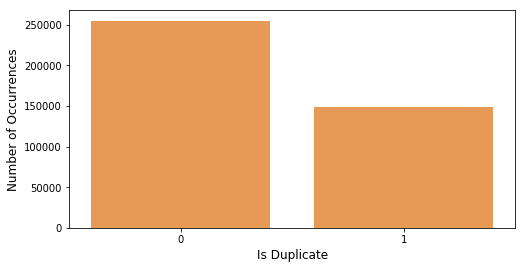

In [12]:
# A plot to see how many is_duplicate is really duplicate (=1) and not really duplicate (=0)
# Approximately 250k (with a tag=0) questions are NOT really duplicate, 
# and only about 150k (with a tag=1) seem to be duplicate. X-axis: Label distribution in data 

print("No of data points: ",df.shape[0])
print(df["is_duplicate"].value_counts()) # show 255024 0's and 149263 1's out of 404287 total is_duplicate counts.

is_dup = df['is_duplicate'].value_counts()
color = sns.color_palette()
plt.figure(figsize=(8,4))

sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])

plt.ylabel('Number of Occurrences', fontsize=12)

plt.xlabel('Is Duplicate', fontsize=12)

plt.show()

In [13]:

# Clean up the text in questions.

# This list is so extensive that we can look back at it as a reference when 
# needed for other regular expression related work.


SPECIAL_TOKENS = {'non-ascii': 'non_ascii_word'}

def clean(text, stem_words=True):
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE) # replace whats by what is and ignore case
    text = re.sub("\'ve", " have ", text) # replace 've by have
    text = re.sub("can't", "can not", text) # replace can't by can not
    text = re.sub("n't", " not ", text) # replace n't by not
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE) # replace i'm by i am and ignore case
    text = re.sub("\'re", " are ", text) # replace 're by are
    text = re.sub("\'d", " would ", text) # replace 'd by would
    text = re.sub("\'ll", " will ", text) # replace 'll by will
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE) # replace e.g. by eg and ignore case
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE) # replace b.g. by bg and ignore case
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text) 
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    # add padding to punctuations and special chars, we still need them later
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) 
    
    # indian dollar
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, 
    # and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Try 1. keeping and 2. removing puncutation to see if the results change.
    # Result: Tried with random forest, there was no change in the result (except a slight change in confusion matrix).
    # Remove punctuation from text.
    text = ''.join([c for c in text if c not in punctuation]).lower()
       
    # Return a list of words
    return text
    
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)



In [14]:
# Look at clean data
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0
5,5,11,12,astrology i am a capricorn sun cap moon and ca...,i am a triple capricorn sun moon and ascendant...,1
6,6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1
8,8,17,18,when do you use nonasciiword instead of non...,when do you use and instead of and,0
9,9,19,20,motorola company can i hack my charter motorol...,how do i hack motorola dcx3400 for free internet,0


In [15]:
# After cleaning the text, we preview those question pairs again.
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

In [16]:
# Use word level CountVectorizer to identify whether qestion1 is duplicate to question2 or not.

# CountVectorizer documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# Use word level CountVectorizer to identify whether qestion1 
# is duplicate to question2 or not.

# r'\w{1,}' means 1 or more words
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}') 

q1_trans = count_vect.fit_transform(df['question1'].values)
q2_trans = count_vect.fit_transform(df['question2'].values)
labels = df['is_duplicate'].values

# Stack two questions using scipy sparse matrix, horizontally (column wise), 
# so as to make X variables as a 2-dimensional matrix, wehre
# we can think of like we have two variables (features): q1_trans, and 
# q2_trans. Here we are not mixing two questions (q1_trans, and q2_trans) 
# to make one bag of words, but we are stacking them side by side 
# (still as two elements in a row of the matrix) to make X as a 2D matrix.

X = scipy.sparse.hstack((q1_trans,q2_trans)) 
y = labels
print(X.shape)
print(y.shape)

(404287, 152570)
(404287,)


In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
#
# Using random forest classifier
#

from sklearn.ensemble import RandomForestClassifier
# build a pipeline using RandomForestClassifier()
rf_clf = Pipeline([('tfidf', TfidfTransformer()),('RF', RandomForestClassifier()),])

# Feed the data through the pipeline
rf_clf.fit(X_train, y_train)   


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impuri...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [19]:
# Form a prediction set using random forest classifier
predictionRF = rf_clf.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictionRF))
print("\nOverall Accuracy:\n    {:.2f}%".format(accuracy_score(y_test, predictionRF) * 100))
print("\nClassification report:\n", metrics.classification_report(y_test,predictionRF))

# Confusion Matrix:
#  [[70289  6320]
#  [20682 23996]]

# Overall Accuracy:
#     77.74%

# Classification report:
#                precision    recall  f1-score   support

#            0       0.77      0.92      0.84     76609
#            1       0.79      0.54      0.64     44678

#    micro avg       0.78      0.78      0.78    121287
#    macro avg       0.78      0.73      0.74    121287
# weighted avg       0.78      0.78      0.77    121287

# The accuracy here is 77.74% which is rather low but far better than the default value of 37%.




Confusion Matrix:
 [[70289  6320]
 [20682 23996]]

Overall Accuracy:
    77.74%

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84     76609
           1       0.79      0.54      0.64     44678

   micro avg       0.78      0.78      0.78    121287
   macro avg       0.78      0.73      0.74    121287
weighted avg       0.78      0.78      0.77    121287



In [20]:
#
# Build a pipeline using linear support vector classifier.
#

# build a pipeline using LinearSVC()
# svc_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('svc', LinearSVC()),])
# Do not use CountVectorizer as explained in here:
# https://stackoverflow.com/questions/50192763/python-sklearn-pipiline-fit-attributeerror-lower-not-found?rq=1
"""
Either remove step ('vect', CountVectorizer()) or use TfidfTransformer instead of TfidfVectorizer 
as TfidfVectorizer expects array of strings as an input and CountVectorizer() returns a matrix of 
occurances (i.e. numeric matrix).

Per default TfidfVectorizer(..., lowercase=True) will try to "lowercase" all strings, hence 
the “AttributeError: lower not found” error message.
"""
# build a pipeline using LinearSVC()
svc_clf = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC()),])

# Feed the data through the pipeline
svc_clf.fit(X_train, y_train)   


Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [21]:
# Form a prediction set using linear support vector classifier.
predictionSV = svc_clf.predict(X_test)

# Get the score report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictionSV))
print("\nOverall Accuracy:\n    {:.2f}%".format(accuracy_score(y_test, predictionSV) * 100))
print("\nClassification report:\n", metrics.classification_report(y_test,predictionSV))


# Confusion Matrix:
#  [[64560 12049]
#  [17106 27572]]

# Overall Accuracy:
#     75.96%

# Classification report:
#                precision    recall  f1-score   support

#            0       0.79      0.84      0.82     76609
#            1       0.70      0.62      0.65     44678

#    micro avg       0.76      0.76      0.76    121287
#    macro avg       0.74      0.73      0.73    121287
# weighted avg       0.76      0.76      0.76    121287


# The accuracy we got is 75.96% with this method. We try another method next to improve it if possible.



Confusion Matrix:
 [[64560 12049]
 [17106 27572]]

Overall Accuracy:
    75.96%

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82     76609
           1       0.70      0.62      0.65     44678

   micro avg       0.76      0.76      0.76    121287
   macro avg       0.74      0.73      0.73    121287
weighted avg       0.76      0.76      0.76    121287



In [22]:
# Use Character Level TF-IDF to identify whether qestion1 is duplicate to question2 or not.

# Note that TF-IDF based method does not perform well when there is no vocabulary overlap 
# but there is semantic similarity between sentences. 
# So we must use word2vec (toward the end section of this project). 

# r'\w{1,}' means 1 or more words
# n-gram means sequence of n words. 
# ngram_range=(2,3) means we use bigrams or trigrams.
# max_features=5000 means we use 5000 columns at maximum.

tfidf_vect_ngram_chars=TfidfVectorizer(analyzer='char',token_pattern=r'\w{1,}',ngram_range=(2,3),max_features=5000)

q1_trans = tfidf_vect_ngram_chars.fit_transform(df['question1'].values)
q2_trans = tfidf_vect_ngram_chars.fit_transform(df['question2'].values)
labels = df['is_duplicate'].values

# Stack two questions, using sparse matrix, horizontally (column wise) 
# so as to make X variable a 2-dimensional matrix, wehre
# we can think of like we have two variables (features): q1_trans, and q2_trans.
# Here we are not mixing two questions (q1_trans, and q2_trans) to make one bag of words, 
# but we are stacking them side by side (still as two elements in a row of the matrix) to make X as a 2D matrix.
X = scipy.sparse.hstack((q1_trans,q2_trans))
y = labels


In [23]:
q1_trans.shape

(404287, 5000)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [25]:
#
# build a pipeline using LinearSVC()
#

svc_clfChar = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC()),])

# Feed the data through the pipeline
svc_clfChar.fit(X_train, y_train)   


Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [26]:
# Form a prediction set
predictionSVchar = svc_clfChar.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictionSVchar))
print("\nOverall Accuracy:\n    {:.2f}%".format(accuracy_score(y_test, predictionSVchar) * 100))
print("\nClassification report:\n", metrics.classification_report(y_test,predictionSVchar))


# Confusion Matrix:
#  [[65707 10902]
#  [20255 24423]]

# Overall Accuracy:
#     74.31%

# Classification report:
#                precision    recall  f1-score   support

#            0       0.76      0.86      0.81     76609
#            1       0.69      0.55      0.61     44678

#    micro avg       0.74      0.74      0.74    121287
#    macro avg       0.73      0.70      0.71    121287
# weighted avg       0.74      0.74      0.74    121287

# The accuracy we got now went down from 75% to 74% with this method - not good.
# We add Xgboost next to improve accuracy.



Confusion Matrix:
 [[65707 10902]
 [20255 24423]]

Overall Accuracy:
    74.31%

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81     76609
           1       0.69      0.55      0.61     44678

   micro avg       0.74      0.74      0.74    121287
   macro avg       0.73      0.70      0.71    121287
weighted avg       0.74      0.74      0.74    121287



In [27]:
# Use Character Level TF-IDF + Xgboost to identify whether qestion1 is duplicate to question2 or not.

# Character Level TF-IDF + Xgboost (Extreme Gradient Boosting)

# XGBoost (Extreme Gradient Boosting):  https://www.datacamp.com/community/tutorials/xgboost-in-python
# XGBoost is an implementation of gradient boosted decision trees designed for speed 
# and performance that is dominative competitive machine learning. It has shown better performance 
# on a variety of machine learning benchmark datasets. XGBoost internally has parameters for 
# cross-validation, regularization, user-defined objective functions, missing values, 
# tree parameters, scikit-learn compatible API etc.

# What is boosting? https://www.datacamp.com/community/tutorials/xgboost-in-python
# Boosting is a sequential technique which works on the principle of an ensemble. 
# It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, 
# the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted 
# correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a 
# weak learner is one which is slightly better than random guessing. For example, a decision tree whose 
# predictions are slightly better than 50%.


# TfidfVectorizer -- Brief Tutorial:  tf: term frequency, idf: inverse document frequency
#https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

# The goal of using tf-idf is to scale down the impact of tokens that occur very frequently 
# in a given corpus and that are hence empirically less informative than features that occur 
# in a small fraction of the training corpus. We want low positive weights for frequent terms 
# and high weights for rare terms.

# TF: How often does the term appear in a document? The more often, the higher the weight.
# IDF: How often does the term appear in all documents in the collection? The more often, the lower the weight.
# The product TF * IDF will scale down the impact of tokens that occur very frequently, but are
# less informative, in the document.

# TF-IDF Source - see last example here: https://en.wikipedia.org/wiki/Tf–idf 

import datetime
st = datetime.datetime.now() # current time

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                              gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, 
                              subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_test)

print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('character level tf-idf test score:', f1_score(y_test, xgb_model.predict(X_test), average='macro'))


print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_prediction))
print("\nOverall Accuracy:\n    {:.2f}%".format(accuracy_score(y_test, xgb_prediction) * 100))
print("\nclassification_report\n", classification_report(y_test, xgb_prediction))

nd = datetime.datetime.now() # end time now
print("Code run-time: ", nd-st) # it's the total time to run the code (finish time -start time)


# character level tf-idf training score: 0.997985723769572
# character level tf-idf test score: 0.8048011235004698

# Confusion Matrix:
#  [[69878  6731]
#  [14418 30260]]

# Overall Accuracy:
#     82.56%

# classification_report
#                precision    recall  f1-score   support

#            0       0.83      0.91      0.87     76609
#            1       0.82      0.68      0.74     44678

#    micro avg       0.83      0.83      0.83    121287
#    macro avg       0.82      0.79      0.80    121287
# weighted avg       0.82      0.83      0.82    121287

# Code run-time:  2:36:07.556734


# Now the accuracy is 82.56% which is the best we have.


character level tf-idf training score: 0.997985723769572
character level tf-idf test score: 0.8048011235004698

Confusion Matrix:
 [[69878  6731]
 [14418 30260]]

Overall Accuracy:
    82.56%

classification_report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87     76609
           1       0.82      0.68      0.74     44678

   micro avg       0.83      0.83      0.83    121287
   macro avg       0.82      0.79      0.80    121287
weighted avg       0.82      0.83      0.82    121287

Code run-time:  2:36:07.556734


In [28]:
#
# All code below this runs independently of any code written above.
#

In [29]:

#
# To capture sentiment, we use MaLSTM neural net.
#

import re
import gensim
import logging
import itertools

import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


# Clean up the text
def text_to_word_list(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()

    return text

# We use the 300-dimensional word2vec embeddings from google which can capture intricate
# inter-word relationships such as vec(king) − vec(man) + vec(woman) ≈ vec(queen).
# This is publicly available at: code.google.com/p/word2vec
def make_w2v_embeddings(df, embedding_dim=300):
    vocabs = {}
    vocabs_cnt = 0
    vocabs_not_w2v = {}
    vocabs_not_w2v_cnt = 0

    stops = set(stopwords.words('english'))

    word2vec = KeyedVectors.load_word2vec_format("/Users/rameshsubedi/Downloads/nlpDownload/GoogleNews-vectors-negative300.bin", binary=True)

    for index, row in df.iterrows():
        if index != 0 and index % 1000 == 0:
            print("{:,} sentences embedded.".format(index), flush=True)

        for question in ['question1', 'question2']:

            q2n = []
            for word in text_to_word_list(row[question]):
                if word in stops:
                    continue
                if word not in word2vec.vocab:
                    if word not in vocabs_not_w2v:
                        vocabs_not_w2v_cnt += 1
                        vocabs_not_w2v[word] = 1
                if word not in vocabs:
                    vocabs_cnt += 1
                    vocabs[word] = vocabs_cnt
                    q2n.append(vocabs_cnt)
                else:
                    q2n.append(vocabs[word])

            df.at[index, question + '_n'] = q2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)
    embeddings[0] = 0

    for word, index in vocabs.items():
        if word in word2vec.vocab:
            embeddings[index] = word2vec.word_vec(word)
    del word2vec

    return df, embeddings


def split_and_zero_padding(df, max_seq_length):
    X = {'q1': df['question1_n'], 'q2': df['question2_n']}

    for dataset, side in itertools.product([X], ['q1', 'q2']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset


class ManhattanDistance(Layer):
    def __init__(self, **kwargs):
        super(ManhattanDistance, self).__init__(**kwargs)
        self.result = None

    def build(self, input_shape):
        super(ManhattanDistance, self).build(input_shape)

    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)
    

In [30]:

import os
import matplotlib

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from time import time
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Input, Embedding, LSTM

matplotlib.use('Agg')

#ROOT_PATH = os.path.abspath('/Users/rameshsubedi/Downloads/kaggle')
ROOT_PATH = os.path.abspath('') # It's /Users/rameshsubedi
TRAIN_CSV = 'train.csv'

gpus = 2
#batch_size = 256 * gpus
batch_size = 128 * gpus

n_epoch = 50 # we will be training the whole data (the training data part) 50 times.
#  To learn more about epoch, batch, look here: 
# https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks
"""
An EPOCH describes the number of times the algorithm sees the entire data set. 
So, each time the algorithm has seen all samples in the dataset, an epoch has completed.

An ITERATION describes the number of times a BATCH of data passed through the algorithm. 
In the case of neural networks, that means (or ITERATION means) the forward pass and backward pass. 
So, every time you pass a batch of data through the NN, you completed an iteration.

Example: if you have 1000 training examples (rows), and your batch size is 500, 
then it will take 2 iterations to complete 1 epoch.

In this analysis there are 404287 rows, and batch size is 256, so it will take 404287/256=1579.246
iterations complete one epoch.

"""
#n_hidden = 256
n_hidden = 128

# using 300 dimension for embedding i.e. there will be 300 vectors for each word in the corpora 
# represented for neural network model.
embedding_dim = 300
max_seq_length = 25  # length of the longest question has 25 words



In [31]:

def prepare_data():
    train_df = pd.read_csv(os.path.join(ROOT_PATH, TRAIN_CSV))
    for q in ['question1', 'question2']:
        train_df[q + '_n'] = train_df[q]

    train_df, embeddings = make_w2v_embeddings(train_df, embedding_dim=embedding_dim)
    #validation_size = int(len(train_df) * 0.1)
    validation_size = int(len(train_df) * 0.3) # 30% for test (here validation means test), 70% for train

    X = train_df[['question1_n', 'question2_n']]
    Y = train_df['is_duplicate']

    #X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=42)


    X_train = split_and_zero_padding(X_train, max_seq_length)
    X_validation = split_and_zero_padding(X_validation, max_seq_length)

    Y_train = Y_train.values
    Y_validation = Y_validation.values

    assert X_train['q1'].shape == X_train['q2'].shape
    assert len(X_train['q1']) == len(Y_train)

    return X_train, X_validation, Y_train, Y_validation, embeddings



In [36]:

def prepare_model(embeddings):
    shared_model = Sequential() 
    # Set trainble=False so that the gradient decent will not optimize the embeddings.
    shared_model.add(Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,), trainable=False))
    shared_model.add(LSTM(n_hidden))

    q1_input = Input(shape=(max_seq_length,), dtype='int32')
    q2_input = Input(shape=(max_seq_length,), dtype='int32')

    malstm_distance = ManhattanDistance()([shared_model(q1_input), shared_model(q2_input)])
    
    # The Model below is due from:  from tensorflow.python.keras.models import Model
    model = Model(inputs=[q1_input, q2_input], outputs=[malstm_distance]) 

    # if gpus >= 2:
    #     model = tf.keras.utils.multi_gpu_model(model, gpus=gpus)
   
   # Adam() from here:   from tensorflow.python.keras.optimizers import Adam
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
    model.summary()
    shared_model.summary()

    return model


In [37]:

def train_model(X_train, X_validation, Y_train, Y_validation, model):
    training_start_time = time()

    checkpointer = ModelCheckpoint(
        filepath=os.path.join(ROOT_PATH, 'model/weights.{epoch:02d}.h5'),
        verbose=1, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', period=1)
        
    malstm_trained = model.fit(
        [X_train['q1'], X_train['q2']], Y_train, batch_size=batch_size, epochs=n_epoch,
        validation_data=([X_validation['q1'], X_validation['q2']], Y_validation), 
        callbacks=[checkpointer])
    
    training_end_time = time()
    print("Training time finished.\n%d epochs in %12.2f" % (n_epoch, training_end_time - training_start_time))

    model.save(os.path.join(ROOT_PATH, 'model/siamese-lstm-weights.h5')) # This file will be created when we run the main function below.

    return malstm_trained



In [38]:
def plot_accuracy_and_loss(malstm_trained):
    plt.subplot(211)
    plt.plot(malstm_trained.history['acc'])
    plt.plot(malstm_trained.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left') 

    plt.subplot(212)
    plt.plot(malstm_trained.history['loss'])
    plt.plot(malstm_trained.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right') 

    plt.tight_layout(h_pad=1.0)
    plt.savefig(os.path.join(ROOT_PATH, 'model/history-graph.png')) # This graph will be made when we run the main function below.
    print(str(malstm_trained.history['val_acc'][-1])[:6] + "(max: " + str(max(malstm_trained.history['val_acc']))[:6] + ")")

2019-04-17 23:58:41,638 : INFO : loading projection weights from /Users/rameshsubedi/Downloads/nlpDownload/GoogleNews-vectors-negative300.bin
2019-04-18 00:00:55,201 : INFO : loaded (3000000, 300) matrix from /Users/rameshsubedi/Downloads/nlpDownload/GoogleNews-vectors-negative300.bin


1,000 sentences embedded.
2,000 sentences embedded.
3,000 sentences embedded.
4,000 sentences embedded.
5,000 sentences embedded.
6,000 sentences embedded.
7,000 sentences embedded.
8,000 sentences embedded.
9,000 sentences embedded.
10,000 sentences embedded.
11,000 sentences embedded.
12,000 sentences embedded.
13,000 sentences embedded.
14,000 sentences embedded.
15,000 sentences embedded.
16,000 sentences embedded.
17,000 sentences embedded.
18,000 sentences embedded.
19,000 sentences embedded.
20,000 sentences embedded.
21,000 sentences embedded.
22,000 sentences embedded.
23,000 sentences embedded.
24,000 sentences embedded.
25,000 sentences embedded.
26,000 sentences embedded.
27,000 sentences embedded.
28,000 sentences embedded.
29,000 sentences embedded.
30,000 sentences embedded.
31,000 sentences embedded.
32,000 sentences embedded.
33,000 sentences embedded.
34,000 sentences embedded.
35,000 sentences embedded.
36,000 sentences embedded.
37,000 sentences embedded.
38,000 sen

298,000 sentences embedded.
299,000 sentences embedded.
300,000 sentences embedded.
301,000 sentences embedded.
302,000 sentences embedded.
303,000 sentences embedded.
304,000 sentences embedded.
305,000 sentences embedded.
306,000 sentences embedded.
307,000 sentences embedded.
308,000 sentences embedded.
309,000 sentences embedded.
310,000 sentences embedded.
311,000 sentences embedded.
312,000 sentences embedded.
313,000 sentences embedded.
314,000 sentences embedded.
315,000 sentences embedded.
316,000 sentences embedded.
317,000 sentences embedded.
318,000 sentences embedded.
319,000 sentences embedded.
320,000 sentences embedded.
321,000 sentences embedded.
322,000 sentences embedded.
323,000 sentences embedded.
324,000 sentences embedded.
325,000 sentences embedded.
326,000 sentences embedded.
327,000 sentences embedded.
328,000 sentences embedded.
329,000 sentences embedded.
330,000 sentences embedded.
331,000 sentences embedded.
332,000 sentences embedded.
333,000 sentences em

2019-04-18 00:05:19,246 : WARNING : From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-04-18 00:05:20,818 : WARNING : From /anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          25976448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
manhattan_distance (ManhattanDi (None, 1)            0           sequential[1][0]                 
          

2019-04-18 00:05:20,990 : WARNING : From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1775 - acc: 0.7521
Epoch 00001: val_loss improved from inf to 0.15933, saving model to /Users/rameshsubedi/model/weights.01.h5
283003/283003 [==============================] - 623s 2ms/sample - loss: 0.1775 - acc: 0.7521 - val_loss: 0.1593 - val_acc: 0.7813
Epoch 2/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.7920
Epoch 00002: val_loss improved from 0.15933 to 0.15051, saving model to /Users/rameshsubedi/model/weights.02.h5
283003/283003 [==============================] - 627s 2ms/sample - loss: 0.1525 - acc: 0.7920 - val_loss: 0.1505 - val_acc: 0.7955
Epoch 3/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.8042
Epoch 00003: val_loss improved from 0.15051 to 0.14625, saving model to /Users/rameshsubedi/model/weights.03.h5
283003/283003 [==============================] - 621s 2ms/sample - loss: 0.1447 - acc: 0.8042 - val_loss: 0.1462 - 

283003/283003 [==============================] - 620s 2ms/sample - loss: 0.1033 - acc: 0.8726 - val_loss: 0.1302 - val_acc: 0.8271
Epoch 26/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1023 - acc: 0.8740
Epoch 00026: val_loss did not improve from 0.13017
283003/283003 [==============================] - 612s 2ms/sample - loss: 0.1023 - acc: 0.8740 - val_loss: 0.1305 - val_acc: 0.8265
Epoch 27/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.8758
Epoch 00027: val_loss did not improve from 0.13017
283003/283003 [==============================] - 612s 2ms/sample - loss: 0.1014 - acc: 0.8758 - val_loss: 0.1303 - val_acc: 0.8274
Epoch 28/50
282880/283003 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.8769
Epoch 00028: val_loss improved from 0.13017 to 0.12990, saving model to /Users/rameshsubedi/model/weights.28.h5
283003/283003 [==============================] - 614s 2ms/sample - loss: 0.1006 - acc: 0.8769 - val

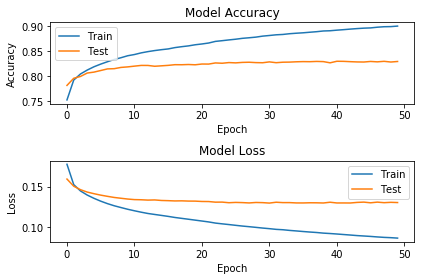

In [39]:
if __name__ == '__main__':
    X_train, X_validation, Y_train, Y_validation, embeddings = prepare_data()
    model = prepare_model(embeddings)
    malstm_trained = train_model(X_train, X_validation, Y_train, Y_validation, model) 
    plot_accuracy_and_loss(malstm_trained)
    

In [ ]:
# Conclusion:

# 1. Based on Character Level TF-IDF + Xgboost (which does not capture the sentiments of question-pairs) 
#    we get the best 'recall' of 68%. That is, the proportion of duplicate questions that our model is 
#    able to detect over the total amount of duplicate questions is 0.68.
#    The maximum accuracy obtined is 82.56%

# 2. To capture the sentiment of question-pairs, we use word2vec embeddings and employ 
#    MaLSTM (Manhattan Long Short-Term Memory) neural network for the analysis.
#    We find question-pair's duplicate accuracy of 82.97%.

# 3. The accuracies obtained from both methods are almost the same.
